In [14]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15.0, 11.0)

### TODOS
- Scale down base data and remove scaling factor

### Comments
- It is a bit weird to argue why the recording ID is already included in the gaze.csv but the wearer ID is not.

# Analysing Areas of Interest with the Reference Image Mapper
Eye tracking recordings contain a plethora of information but the analysis required to extract this information is often a difficult and laborious task. One of the most common types of analysis is to compare the gaze behavior of subjects in relation to a set of objects. In a motor control study one might be interested in how gaze is distributed over a bunch of obstacles, in a user interface design study one might care about different elements of the interface, and in a marketing study I might care about gaze on different products in a shelf.

Typical questions asked in these settings are
- Which object was looked at the most?
- Which object was looked at first?
- What percentage of subjects looked at each object at least once?

All those applications require knowledge about when the gaze of a subject was on an object of interet and when it was not. Traditionally, researchers have to manually go through all the recordings and annotate when which object was visible in the scene and if the gaze was on them at the time. Using the Reference Image Mapper in Pupil Cloud it is possible to map gaze onto a reference image of the objects of interest automatically, enabling all of the above analysis.

In this tutorial we will take a detailed look at how the export of a Reference Image Mapper enrichment can be used for exactly this purpose. We will use an example dataset from a supermarket study where subjects were asked to buy products from different categories including ground coffee. We will consider the different products available in the coffee shelf as our objects of interest and explore how the subjects distributed their gaze over the shelf using classic eye tracking metrics. Utilizing the Reference Image Mapper and a couple of common Python libraries we can implement this very easily.

### Reference Image Mapper Export
Let's take a look at how the export of the Reference Image Mapper looks like and list the included files!

In [16]:
import os

export_path = "reference_image_mapper-coffee/"
os.listdir(export_path)

['reference_image.jpeg', 'gaze.csv', 'sections.csv']

**reference_image.jpeg**: This is the reference image that was used to generate the mapping, i.e. all gaze data is available in pixel coordinates of this image!

**gaze.csv**: This CSV file contains the mapped gaze date from all subjects.

**sections.csv**: This CSV file denotes what sections of the original recordings have been analyzed by the Reference Image Mapper. In this case we have only analyzed those setctions of the recordings where the subjects have been in the coffee isle. Also it contains meta information like who the subject was that corresponds to every section.

For a detailed overview on everything that is included please see the [docs](https://docs.pupil-labs.com/cloud/enrichments/#export-format-2).

Let's take a look at the reference image so we get an idea of what we are working with!

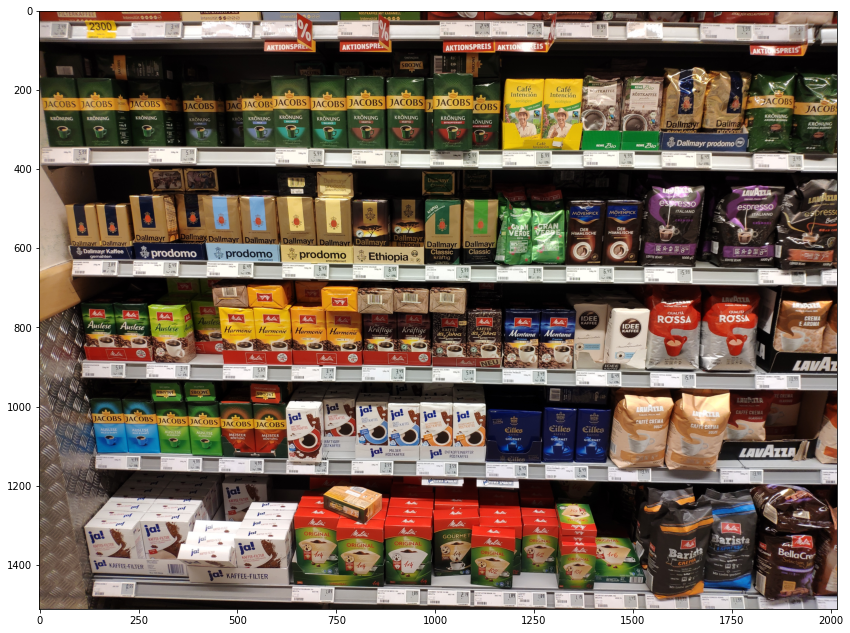

In [17]:
import cv2
import matplotlib.pyplot as plt

scaling_factor = 0.5
ref_img_bgr = cv2.imread(os.path.join(export_path, "reference_image.jpeg"))
ref_img_bgr = cv2.resize(ref_img_bgr, dsize=None, fx=scaling_factor, fy=scaling_factor)

# OpenCV reads images in BGR format, but matplotlib expects them in RGB, so we convert
ref_img = cv2.cvtColor(ref_img_bgr, cv2.COLOR_BGR2RGB)


plt.imshow(ref_img)

### Annotating Areas of Intrerest

The reference image is showing the entire shelf with all it's products. To compare the different products with one another we first need to annotate them in the image as areas of interest (AOI). OpenCV includes a tool for exactly this task, which makes our lifes very easy! Using `cv2.selectROIs` we get a GUI we can use to draw the bounding boxes directly into the image. See the [OpenCV docs](https://docs.opencv.org/3.4/d7/dfc/group__highgui.html#ga0f11fad74a6432b8055fb21621a0f893) for details.

In [18]:
aois = cv2.selectROIs("AOI Annotation", ref_img_bgr)
cv2.destroyAllWindows()

After annotation we end up with the following AOIs:

In [19]:
import numpy as np

aois = np.array([
    (0, 80, 372, 264),
    (368, 83, 222, 259),
    (593, 71, 184, 274),
    (779, 73, 198, 274),
    (978, 79, 193, 271),
    (1169, 81, 208, 271),
    (1368, 84, 208, 268),
    (1567, 88, 236, 264),
    (1788, 91, 227, 266),
    (72, 391, 347, 240),
    (419, 400, 194, 235),
    (612, 395, 181, 243),
    (795, 403, 178, 236),
    (974, 404, 190, 236),
    (1156, 401, 176, 243),
    (1329, 403, 192, 241),
    (1523, 409, 348, 236),
    (105, 677, 179, 209),
    (283, 682, 177, 204),
    (467, 682, 172, 212),
    (636, 680, 181, 216),
    (819, 688, 171, 207),
    (990, 688, 181, 214),
    (1174, 688, 175, 219),
    (1347, 691, 193, 214),
    (1535, 698, 281, 208),
    (134, 930, 166, 188),
    (301, 934, 154, 185),
    (462, 938, 166, 189),
    (631, 942, 172, 195),
    (801, 942, 164, 191),
    (961, 944, 170, 192),
    (1127, 947, 148, 192),
    (1270, 954, 177, 188),
    (1439, 962, 302, 185)
])

We can use matplotlib to visualize the annotation result.

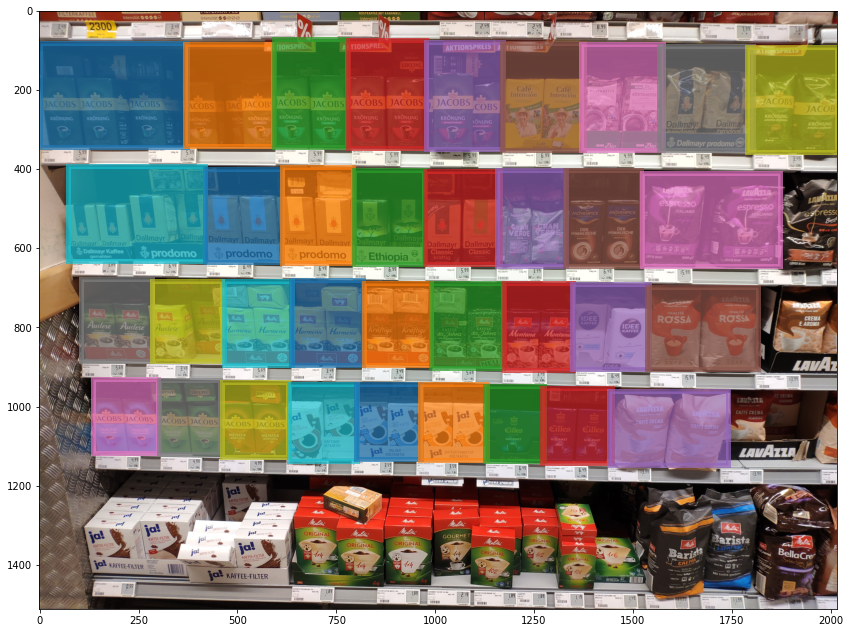

In [20]:
import matplotlib.patches as patches

def visualize_aois(colors = None, fill=False):
    
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        
    plt.imshow(ref_img)
    ax = plt.gca()

    for idx, aoi in enumerate(aois):
        edgecolor = colors[idx % len(colors)]
        facecolor = colors[idx % len(colors)] if fill else "none"
        alpha = .7 if fill else 1.0
        
        x, y, width, height = aoi
        rect = patches.Rectangle((x, y), width, height, linewidth=5, edgecolor=edgecolor, facecolor=facecolor, alpha=alpha)
        ax.add_patch(rect)

visualize_aois(fill=True)

### Mapping Gaze to AOIs

Now that we have the AOIs annotated, we can map the gaze data coming from the Reference Image Mapper export to them. We use `Pandas` to read the `gaze.csv` file that contains all gaze samples and print the first couple of lines for illustration.

In [23]:
import pandas as pd

gaze = pd.read_csv(os.path.join(export_path, "gaze.csv"))
gaze["gaze position in reference image x [px]"] *= scaling_factor
gaze["gaze position in reference image y [px]"] *= scaling_factor

gaze.head()

section id                          recording id  \
0  4029c324-584d-4589-b0e8-da3edac4bd0f  02da87d3-d27a-4eee-92b6-4d44c22c362f   
1  4029c324-584d-4589-b0e8-da3edac4bd0f  02da87d3-d27a-4eee-92b6-4d44c22c362f   
2  4029c324-584d-4589-b0e8-da3edac4bd0f  02da87d3-d27a-4eee-92b6-4d44c22c362f   
3  4029c324-584d-4589-b0e8-da3edac4bd0f  02da87d3-d27a-4eee-92b6-4d44c22c362f   
4  4029c324-584d-4589-b0e8-da3edac4bd0f  02da87d3-d27a-4eee-92b6-4d44c22c362f   

        timestamp [ns]  gaze detected in reference image  \
0  1614328230204761483                             False   
1  1614328230208849483                             False   
2  1614328230212734483                             False   
3  1614328230220853483                             False   
4  1614328230224885483                             False   

   gaze position in reference image x [px]  \
0                                      NaN   
1                                      NaN   
2                                      NaN   
3                                      NaN   
4                                      NaN   

   gaze position in reference image y [px]  
0                                      NaN  
1                                      NaN  
2                                      NaN  
3                                      NaN  
4                                      NaN

The mapped gaze data contains a sample for every gaze sample included in the original recording sections, including samples that could not be mapped to the reference image successfully. Using the `gaze detected in reference image` column we filter those out.

In [24]:
gaze = gaze[gaze["gaze detected in reference image"]]

For every AOI we can no check if the gaze samples lie within it's respective bounds using the `between` method of Pandas Dataframes.

In [28]:
for idx, aoi in enumerate(aois):
    gaze[idx] = False
    x, y, width, height = aoi
    
    x_check = gaze["gaze position in reference image x [px]"].between(x, x + width)
    y_check = gaze["gaze position in reference image y [px]"].between(y, y + height)
    gaze[idx] =  x_check & y_check

Using this information we can now easily visualize the gaze points belonging to every AOI.

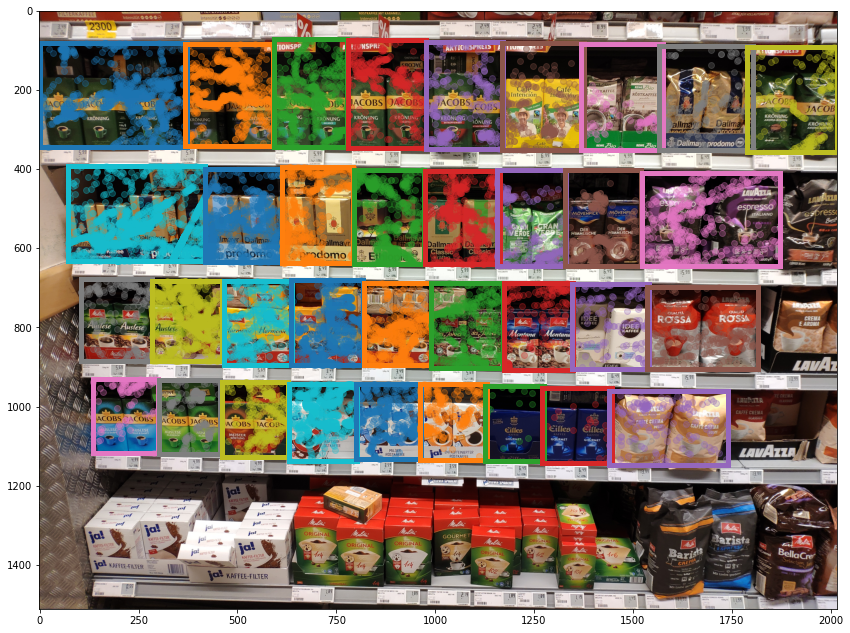

In [32]:
visualize_aois()

for idx, aoi in enumerate(aois):    
    d = gaze[gaze[idx]]
    plt.scatter(d["gaze position in reference image x [px]"], d["gaze position in reference image y [px]"], alpha=0.3)

### Calculating Metrics

Given the gaze data belonging to every AOI we can now calculate classic eye tracking metrics enabling quantitative analysis.

#### Dwell Time

The dwell time metrics sums up how much time an AOI has been looked at in total by all subjects. It is one of the most commonly used metrics in eye tracking. We can calculate it by counting the number of gaze samples belonging to every AOI and multiplying that with `5 milliseconds`, which is the average duration of a gaze sample at a 200 Hz recording framerate.

In [40]:
def val2color(data, vmax=None):
    if vmax is None:
        vmax = np.max(data)
    
    norm = mpl.colors.Normalize(vmin=np.min(data), vmax=vmax)
    cmap = mpl.cm.magma
    m = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

    colors = [m.to_rgba(v) for v in data]
#     colors = np.vstack(colors)
    
    return colors, m

Text(0.5, 1.0, 'Dwell Time')

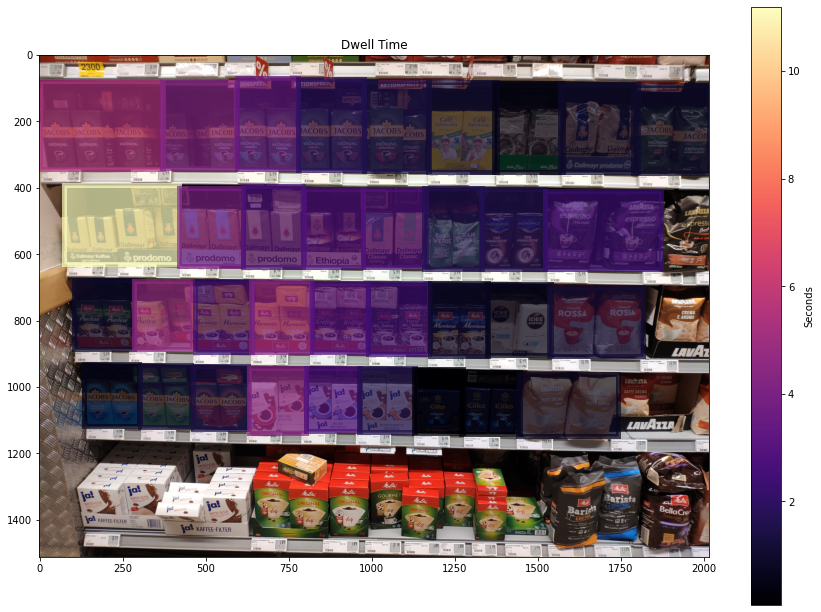

In [49]:
import matplotlib as mpl

results = []
for idx in range(len(aois)):
    # We divide by 1000 to convert milliseconds to seconds
    x = len(gaze[gaze[idx]]) * 5 / 1000
    results.append(x)

colors, cm = val2color(results)
visualize_aois(colors, fill=True)

plt.colorbar(cm, label="Seconds")
plt.title("Dwell Time")

#### Reach

The reach metric measures what percentage of subjects has looked at least once at a given AOI. To calculate this we need the additional information of what subject each section corresponds to, which is included in the `sections.csv` file.

In [50]:
sections = pd.read_csv(os.path.join(export_path, "sections.csv"))
sections.head()

section id                          recording id  \
0  4029c324-584d-4589-b0e8-da3edac4bd0f  02da87d3-d27a-4eee-92b6-4d44c22c362f   
1  1b08cdcb-dcf8-42b9-8766-b515fbc16c56  30eea4a8-419c-4e34-b859-24c33e4934cd   
2  63275840-0b97-437e-aa85-9dc9dc32a9fb  bfe7bbbd-51b8-4a2f-8d3a-853e53866dc0   
3  126e80c1-3ba6-48cd-8076-fd88f470aed3  93494789-a7ed-41da-ad48-02fe29171e8e   
4  d89131f7-a5e6-4b0d-9a6b-681a8cdd02ef  a6ae3a7f-9018-4ed3-959d-5733a76b13f2   

  recording name                             wearer id  wearer name  \
0    Subject 120  ec02f3c7-b5ba-46f5-a7b8-99a054816d6a          120   
1      Subject 2  ad80a1f2-bd81-48fa-9281-c54fe31bd497          105   
2      Subject 6  cabb6266-a63a-48db-80c7-ea296f55d4fb          111   
3      Subject 7  2f927e16-5893-4b1f-8c66-1476595329b1          113   
4      Subject 1  69c7b2f6-1dbf-441e-b2ed-dd99a8d0333b          101   

   section start time [ns]  section end time [ns] start event name  \
0      1614328230202000000    1614328287644000000     coffee_start   
1      1614344453310000000    1614344519320000000     coffee_start   
2      1614352735451000000    1614352763745000000     coffee_start   
3      1614356095494000000    1614356119570000000     coffee_start   
4      1614334480223000000    1614334495286000000     coffee_start   

  end event name  
0     coffee_end  
1     coffee_end  
2     coffee_end  
3     coffee_end  
4     coffee_end

Text(0.5, 1.0, 'Reach - Percentage of subjects looking at the AOI')

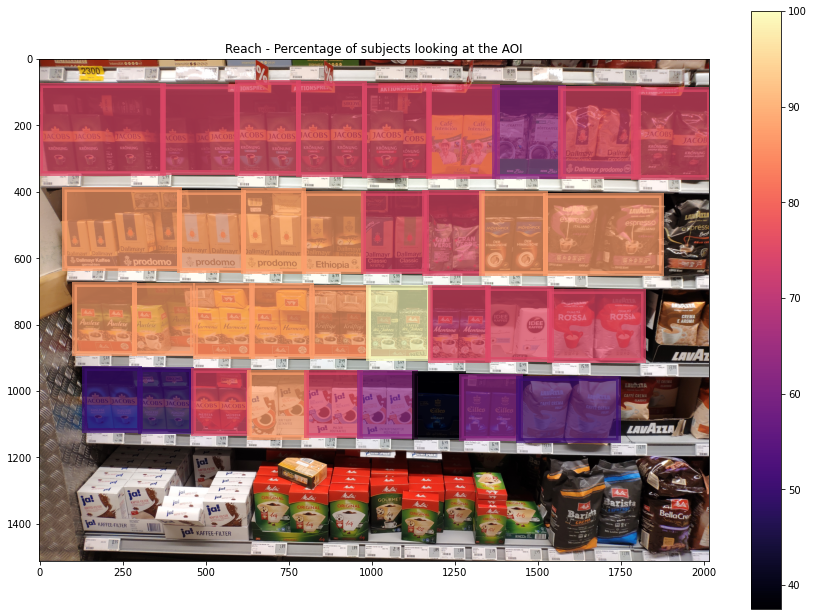

In [52]:
df = pd.merge(gaze, sections, left_on="section id", right_on="section id")

results = []
for idx, aoi in enumerate(aois):
    # The colums for each aoi contain boolean values, where True means "gaze is on the AOI".
    # Thus, taking the maximum of the column tells us if at least one True value is in the column.
    x = df.groupby("wearer id")[idx].max().sum() / df["wearer id"].nunique() * 100
    results.append(x)
    
colors, cm = val2color(results)
visualize_aois(colors, fill=True)

plt.colorbar(cm)
plt.title("Reach - Percentage of subjects looking at the AOI")

#### Time to First Contact

The time to first contact metric measures how long it takes a subject on average to look at an AOI for the first time. Since the subjects in this dataset have not been standing in front of the shelf simultaniously, we need to align their data temporally to make this comparison. Every enrichment sections starts at the moment the subjects approach the shelf and we will start counting time at that moment.

Text(0.5, 1.0, 'Time to first contact')

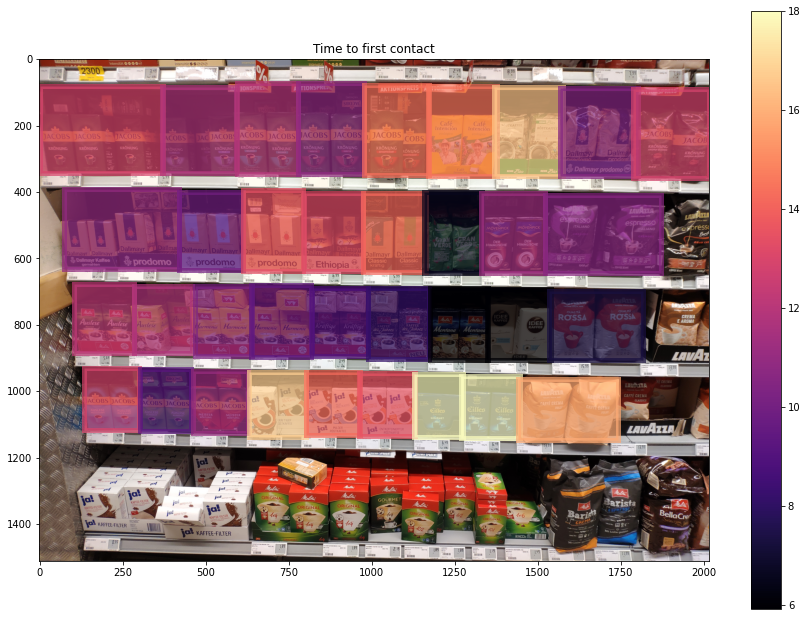

In [54]:
df["time aligned"] = df["timestamp [ns]"] - df["section start time [ns]"]

results = []
for idx in range(len(aois)):
    def time_to_first_contact(df):
        df = df[df[idx]]
        return df["time aligned"].min() / 1e9
    
    x = df.groupby("wearer id").apply(time_to_first_contact).mean()
    results.append(x)

colors, cm = val2color(results, vmax=18)
visualize_aois(colors, fill=True)

plt.colorbar(cm)
plt.title("Time to first contact")

### Conclusion

In this tutorial we have used the exports of a Reference Image Mapper enrichment to calculate several typical eye tracking metrics. Using an examplatory dataset from a supermarket study we have seen how we can do quantitative analysis of gaze behavior using only a few common Python libraries.

If you have further questions or any feedback please let us know! You can send us an email to [info@pupil-labs.com](mailto:info@pupil-labs.com) or chat with us on [Discord](https://pupil-labs.com/chat/)!